<a href="https://colab.research.google.com/github/gmihaila/machine_learning_toolbox/blob/master/fcn_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fully Convolutional Networks for Semantic Segmentation

[Original Paper](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)

http://deeplearning.net/tutorial/fcn_2D_segm.html 

Deconvolution:
https://keras.rstudio.com/reference/layer_conv_2d_transpose.html
https://keras.io/layers/convolutional/#conv2dtranspose 

In [1]:
# used to clean console
from IPython.display import clear_output

# example link: https://drive.google.com/open?id=1mq4pg5Ch1Ypc5Dl5FtuZJkASBCqUojEj

print("Install pydot")
!apt-get -qq install -y graphviz && pip install -q pydot
clear_output()

print("Downloading gdown.pl...")
!wget https://raw.githubusercontent.com/pavanjadhaw/gdown.pl/master/gdown.pl && chmod u+x gdown.pl
clear_output()

print("Downloading google drive file...")
!./gdown.pl "https://drive.google.com/file/d/0B_60jvsCt1hhZWNfcW4wbHE5N3M/view" data.zip
clear_output()

print("Unzip...")
!unzip data.zip
clear_output()

print("Done!")
!ls

Done!
all			      data.zip	  gdown.pl.3	      sample_data
All			      gdown.pl	  labeled_imaged.csv
all_dominos_image+labels.zip  gdown.pl.1  polyps_split7
all.zip			      gdown.pl.2  polyps_split7.zip


In [0]:
import os, sys
import numpy as np
from IPython.display import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure

from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.utils.vis_utils import plot_model
import cv2


im_w, im_h = 228, 228


path_train = "./polyps_split7/train"
path_valid = "./polyps_split7/valid"
path_test  = "./polyps_split7/test"

# TRAIN
images_train = [path_train+"/images/"+im for im in os.listdir("%s/images"%path_train)]
mask2_train  = [path_train+"/masks2/"+im for im in os.listdir("%s/masks2"%path_train)]
mask3_train  = [path_train+"/masks3/"+im for im in os.listdir("%s/masks3"%path_train)]
mask4_train  = [path_train+"/masks4/"+im for im in os.listdir("%s/masks4"%path_train)]

# VALIDATION
images_valid = [path_valid+"/images/"+im for im in os.listdir("%s/images"%path_valid)]
mask2_valid  = [path_valid+"/masks2/"+im for im in os.listdir("%s/masks2"%path_valid)]
mask3_valid  = [path_valid+"/masks3/"+im for im in os.listdir("%s/masks3"%path_valid)]
mask4_valid  = [path_valid+"/masks4/"+im for im in os.listdir("%s/masks4"%path_valid)]

# TEST
images_test = [path_test+"/images/"+im for im in os.listdir("%s/images"%path_test)]
mask2_test  = [path_test+"/masks2/"+im for im in os.listdir("%s/masks2"%path_test)]
mask3_test  = [path_test+"/masks3/"+im for im in os.listdir("%s/masks3"%path_test)]
mask4_test  = [path_test+"/masks4/"+im for im in os.listdir("%s/masks4"%path_test)]


c = []
a = imread("polyps_split7/train/images/CVC-612_612.bmp")
c.append(a)
b = imread("polyps_split7/train/images/CVC-300_001.bmp")
c.append(b)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


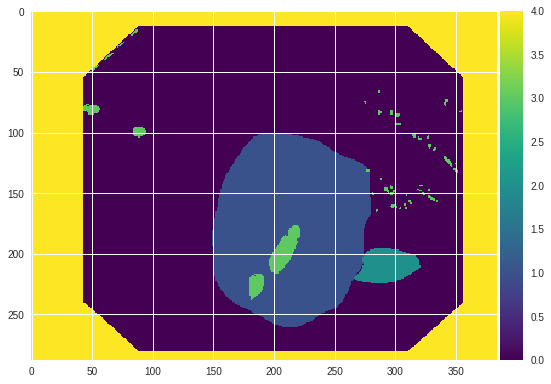

In [3]:
# test show image
imshow(imread(mask4_test[-1]))

In [0]:
def get_data(images, mask1, mask2, mask3, im_h, im_w):
  X, y1, y2, y3 = [], [], [], []
  [X.append(resize(imread(im),(im_h, im_w))) for im in images]
  X = np.array(X)
  [y1.append(resize(imread(im),(im_h, im_w))) for im in mask1]
  
  y1 = [y.reshape(im_h, im_w, 1) for y in y1]
  y1 = np.array(y1)
  [y2.append(resize(imread(im),(im_h, im_w))) for im in mask2]
  
  y2 = [y.reshape(im_h, im_w, 1) for y in y2]
  y2 = np.array(y2)
  [y3.append(resize(imread(im),(im_h, im_w))) for im in mask3]
  
  y3 = [y.reshape(im_h, im_w, 1) for y in y3]
  y3 = np.array(y3)
  
  return X, y1, y2, y3

In [5]:
X_tr, y1_tr, y2_tr, y3_tr = get_data(images_train, mask2_train, mask3_train, mask4_train, im_h, im_w)

X_vl, y1_vl, y2_vl, y3_vl = get_data(images_valid, mask2_valid, mask3_valid, mask4_valid, im_h, im_w)

# test
print(X_tr.shape, y1_tr.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(547, 228, 228, 3) (547, 228, 228, 1)


In [16]:
# build model
model_input = Input(shape=(im_h, im_w,3), name='INPUT')

model_layer = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='Conv1')(model_input)
model_layer = MaxPooling2D(pool_size=(2, 2), name='Pool1')(model_layer)

model_layer = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='Conv2')(model_layer)
model_layer = MaxPooling2D(pool_size=(2, 2), name='Pool2')(model_layer)

model_layer = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same', name='Conv3')(model_layer)
model_layer = UpSampling2D(size=(2, 2), name='unPool3')(model_layer)

model_layer = Conv2DTranspose(filters=1, kernel_size=3, activation='relu', padding='same', name='Conv4')(model_layer)
model_output = UpSampling2D(size=(2, 2), name='unPool4')(model_layer)

model = Model([model_input], model_output)

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# check model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 228, 228, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 228, 228, 32)      896       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 114, 114, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 114, 114, 64)      18496     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 57, 57, 64)        0         
_________________________________________________________________
Conv3 (Conv2DTranspose)      (None, 57, 57, 32)        18464     
_________________________________________________________________
unPool3 (UpSampling2D)       (None, 114, 114, 32)      0         
__________

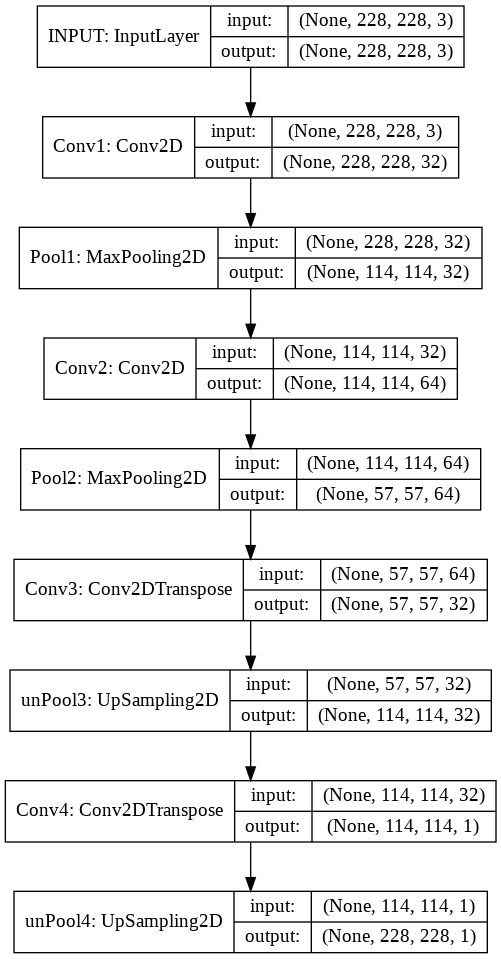

In [17]:
# image model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png')

In [19]:
model.fit(X_tr,y1_tr, epochs=1, batch_size=10, validation_split=0.1)

Train on 492 samples, validate on 55 samples
Epoch 1/1
492/492 [==============================] - 63s 129ms/step - loss: 0.0215 - acc: 0.6508 - val_loss: 0.0168 - val_acc: 0.6609


In [0]:
y_pred = model.predict(X_vl[0:15])
y_pred = [y.reshape(im_h, im_w) for y in y_pred]

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


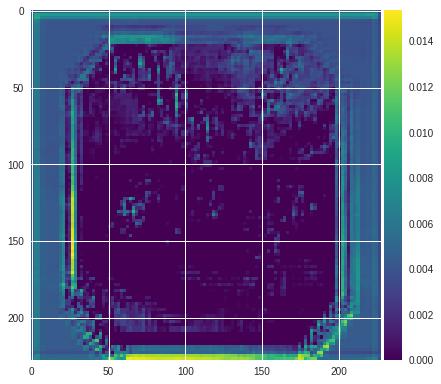

In [27]:
imshow(y_pred[0])


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


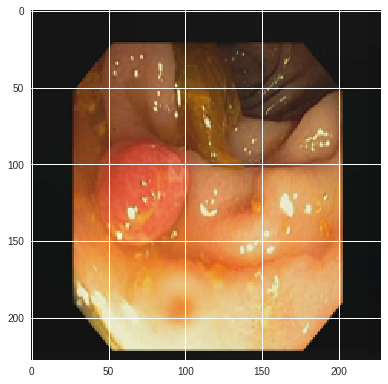

In [25]:
imshow(X_vl[0])